This notebook will explore a dataset containing information on Sudan's violent histories over the past three decades along with the GDP deflator value to measure the change in prices of the year to see if there is an economic correlation with violence in Sudan, potentially elucidating current civil war correlation.

In the notebook, I will perform

1.) Check on the dataset integrity first

2.) Explore unique value for location and see if there is a clear path to grouping location

3.) Explore distribution of violent events

4.) Time Series of violent events and GDP deflators

5.) Pearsons correlation between GDP deflator and mortalities from violent events

6.) Inferential statistics on different locations and the fatality distributions (z-test)

Imports:

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

1.) Dataset integrity

In [438]:
df = pd.read_csv('Desktop/historical_merged_dataset.csv')

In [440]:
df.head()

,Unnamed: 0,year,where_coordinates,total_deaths,GDP Deflator Value
0,31,1989,Rumbek town,12.0,51.551934
1,21,1989,Kadugli town,61.0,51.551934
2,23,1989,Kajo Kaji town,1.0,51.551934
3,24,1989,Kurmuk town,2.0,51.551934
4,25,1989,Road between towns of Juba and Yei,0.0,51.551934


In [442]:
df = df.drop(columns='Unnamed: 0')

In [444]:
df.head()

,year,where_coordinates,total_deaths,GDP Deflator Value
0,1989,Rumbek town,12.0,51.551934
1,1989,Kadugli town,61.0,51.551934
2,1989,Kajo Kaji town,1.0,51.551934
3,1989,Kurmuk town,2.0,51.551934
4,1989,Road between towns of Juba and Yei,0.0,51.551934


In [446]:
df.isna().sum()

year                  0
where_coordinates     0
total_deaths          0
GDP Deflator Value    0
dtype: int64

In [448]:
df.describe()

,year,total_deaths,GDP Deflator Value
count,3822.000000,3822.000000,3822.000000
mean,2009.727891,18.663004,391.800925
std,9.185275,86.719343,1000.815022
min,1989.000000,0.000000,26.445371
25%,2003.000000,0.000000,42.956908
50%,2011.000000,2.000000,75.895076
75%,2016.000000,9.000000,100.000000
max,2023.000000,2700.000000,3562.748256


In [450]:
df.dtypes

year                    int64
where_coordinates      object
total_deaths          float64
GDP Deflator Value    float64
dtype: object

In [452]:
df.duplicated().sum()

777

In [454]:
df = df.drop_duplicates(keep='first')

In [456]:
df = df.reset_index(drop='True')

In [458]:
df.shape

(3045, 4)

Now there are 3000 datapoints to work with

2.) Violent Locations Exploration

In [573]:
df['where_coordinates'].tail(30)

3015             El Obeid town
3016                Nyala town
3017             Khartoum city
3018           Menawashei town
3019              Dilling town
3020             Omdurman town
3021                Nyala town
3022       Faraj Allah village
3023             Omdurman town
3024             Omdurman town
3025        El Mek Nimr bridge
3026                Nyala town
3027                 Kass town
3028             Omdurman town
3029    Sharq El Nile district
3030           El Geneina town
3031           El Geneina town
3032             Khartoum city
3033             Khartoum city
3034             Omdurman town
3035             Khartoum city
3036                Nyala town
3037               Tawila town
3038            Khartoum state
3039             Zalingei town
3040                 Kass town
3041             Khartoum city
3042                Nyala town
3043               Tawila town
3044               Kulbus town
Name: where_coordinates, dtype: object

In [201]:
df['where_coordinates'].nunique()

1006

Out of the almost 3000 data points, 1000 locations are unique.

For a strategy, lets pull out the biggest cities in sudan into a list from wikipedia.  If the city is present in the location, then mark it https://en.wikipedia.org/wiki/List_of_cities_in_Sudan

In [204]:
sud_cit = pd.read_csv("Downloads/sudanese_cities - Sheet1.csv")

In [206]:
sud_cit.head()

,Abekr
0,Abushneib
1,Abyei
2,Al Fashir
3,Al Managil
4,Al-Sireha


In [231]:
sud_cit_list = [x for x in sud_cit['Abekr']]

In [233]:
sud_cit_list.append('Abekr')

In [235]:
print(sud_cit_list)

['Abushneib', 'Abyei', 'Al Fashir', 'Al Managil', 'Al-Sireha', 'Al Qadarif', 'Atbara', 'Babanusa', 'Berber', 'Buwaidhaa', 'Delgo', 'Dongola', 'Ad-Damazin', 'Ed Dueim', 'El Ait', 'El Gebir', 'En Nahud', 'El-Obeid', 'Er Rahad', 'Dinder', 'Foro Baranga', 'Geneina', "Hala'ib", 'Hashabah', '`Iyāl Bakhīt', 'Jebel Moon or Jebel Mun', 'Kaduqli', 'Kassala', 'Kauda', 'Khartoum - Capital', 'Khartoum North or Bahri', 'Kusti or Kosti', 'Kreinik', 'Merowe', 'Muglad', 'Nebelat el Hagana', 'New Halfa or Halfa Aljadeda', 'Nyala', 'Omdurman', 'Port Sudan or Bur Sudan', 'Rabak', 'Ruaba or Umm Rawaba', 'Safita al-Ghunomab', 'Saqiaah', 'Sennar or Sannar', 'Shendi or Shandi', 'Sindscha', 'Singa', 'Suakin', 'Tabat or Al Shaikh Abdulmahmood', 'Taiyara', 'Tambul', 'Wad An Nora', 'Wad Banda', 'Wad Madani or Wad Medani', 'Wadi Halfa', 'Umm Badr', 'Umm Bel', 'Umm Dam', 'Umm Debbi', 'Umm Gafala', 'Umm Keddada', 'Umm Qantur', 'Um Rawaba', 'Umm Saiyala', 'Umm Shanqa', 'Zalingei', 'Abekr']


Lets create a function to check location with the city list

In [249]:
def city_locator(df, col, city_list):

    indices = []

    for x in range(len(df[col])):
        
        location_words = list(df[col][x].split(' '))
        
        for y in location_words:
            
            if y in city_list:
                
                indices.append(x)


    return indices
                

In [251]:
big_city_events = city_locator(df, 'where_coordinates', sud_cit_list)

In [253]:
print (len(big_city_events))

260


Big city subdivision only works on 7-8% of the data with this method.  Lets try and subdivide based on Sudanese states found on wikipedia https://en.wikipedia.org/wiki/States_of_Sudan

In [257]:
sud_states_df = pd.read_csv("Downloads/sudanese_states - Sheet1.csv")

In [259]:
sud_states_list = [x for x in sud_states_df['States']]

In [261]:
print (len(sud_states_list))

18


In [263]:
def state_locator(df, col, state_list):

    indices = []

    for x in range(len(df[col])):
        
        location_words = list(df[col][x].split(' '))
        
        for y in location_words:
            
            if y in state_list:
                
                indices.append(x)


    return indices

In [265]:
state_events = state_locator(df, 'where_coordinates', sud_states_list)

In [267]:
print (len(state_events))

170


States only cover 5%

Lets merge the two functions to see if we can contain 15% of the data

In [271]:
def event_locator_count(df, col, event_dict):

    dict_length = len([k for k,v in event_dict.items()])
    indices = []

    for x in range(len(df[col])):
        
        location_words = list(df[col][x].split(' '))
        
        for y in location_words:

            for z in range(dict_length):
            
                if y in event_dict[z]:
                
                    indices.append(x)

    no_duplicates = set(indices)

    return len(indices), len(no_duplicates)

In [273]:
location_merged = event_locator_count(df, 'where_coordinates', {0:sud_cit_list, 1:sud_states_list})

In [275]:
print (location_merged)

(430, 372)


This search method recovers around 15% of the data 

In [575]:
def state_city_df(df, col, event_dict):

    dict_length = len([k for k,v in event_dict.items()])
    indices = []

    for x in range(len(df[col])):
        
        location_words = list(df[col][x].split(' '))
        
        for y in location_words:

            for z in range(dict_length):
            
                if y in event_dict[z]:
                
                    indices.append([x, z, event_dict[z].index(y)])


    new_df = df.iloc[[x[0] for x in indices], :]

    return new_df

In [294]:
spec_loc_df = state_city_df(df, 'where_coordinates', {0:sud_cit_list, 1:sud_states_list})

In [300]:
spec_loc_df.shape

(430, 4)

Attempt to use the location specifier to bin locations into groups:



In [639]:
loc_descr = ['village', 'town', 'city', 'district','state', 'camp', 'locality', 'area']

In [641]:
def location_grouper(df, col, word_list):

    indices = []

    for x in range(len(df[col])):
        
        location_word = list(df[col][x].split(' '))[-1]
        
        if location_word in loc_descr:
                
            indices.append(location_word)

        else:
            indices.append('other')

    df['general_location'] = indices


    return df

In [643]:
group_df = location_grouper(df,'where_coordinates',loc_descr)

In [645]:
group_df.head()

,year,where_coordinates,total_deaths,GDP Deflator Value,general_location
0,1989,Rumbek town,12.0,51.551934,town
1,1989,Kadugli town,61.0,51.551934,town
2,1989,Kajo Kaji town,1.0,51.551934,town
3,1989,Kurmuk town,2.0,51.551934,town
4,1989,Road between towns of Juba and Yei,0.0,51.551934,other


In [647]:
group_df.general_location.value_counts()

general_location
town        1163
village      607
state        414
district     356
other        305
area          79
camp          43
city          42
locality      36
Name: count, dtype: int64

In [649]:
df[df['general_location']== 'other'].where_coordinates.unique()

array(['Road between towns of Juba and Yei', 'Eastern Sudan', 'Kordofan',
       'Upper Nile province', 'Equatoria', 'Korongo Abdullah hill',
       'Southern Kordofan province', 'Southern Darfur province', 'Darfur',
       'Southern Sudan', 'Bahr al Ghazal\xa0province',
       'Between Maridi and Yei',
       '440 km from Darfur (representation point)',
       'Sudan/Chad border (near)',
       'Between Wau and Gogrial in southern Bahr al-Ghazal',
       'Western Equatoria province', 'Pibor Post', 'Lotuke', 'Lol river',
       'Train from Babanussa to Wau', 'Kuac Deng', 'Wanding payam',
       'Ugandan border (near)', 'Between Equatoria and Bahr al-Ghazal',
       'Road between Lagawa to Dilling (Nuba Mountains)', 'Karnoi wells',
       'Moro hills', 'Otoro hills', 'Sudan', 'Nuer area of Ganyliel',
       'Lomiyega location', 'Bahr al Ghazal', 'Keili garrision',
       'Khor Marafidoy valley', 'Khor el Gana', 'Roseires Dam',
       'Kassala-Butana bridge', 'Western Bahr-al-Ghazal\xa0s

3.) Distribution of Violent Offense

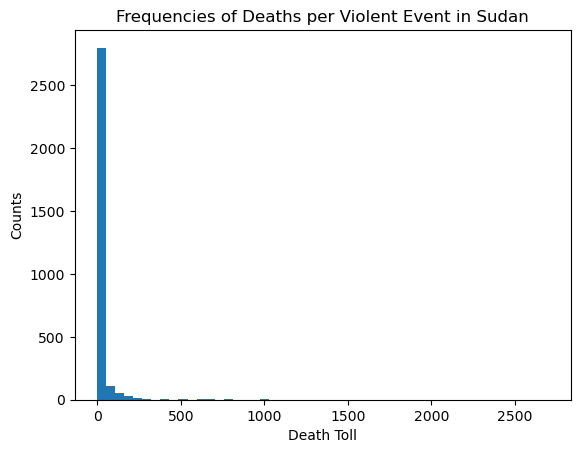

In [350]:
plt.hist(df['total_deaths'], bins=50)
plt.xlabel('Death Toll')
plt.ylabel('Counts')
plt.title('Frequencies of Deaths per Violent Event in Sudan')
plt.show()

Now lets take a closer look at the histogram's left side

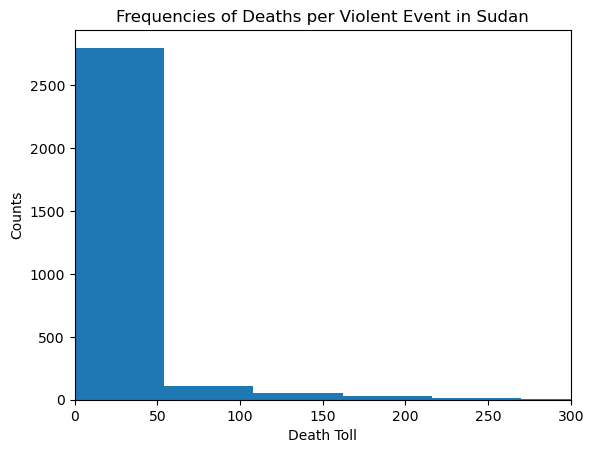

In [348]:
plt.hist(df['total_deaths'], bins=50)
plt.xlabel('Death Toll')
plt.ylabel('Counts')
plt.title('Frequencies of Deaths per Violent Event in Sudan')


plt.ylim(0, None)
plt.xlim(0, 300)
plt.show()

In [359]:
print (sum(df['total_deaths']))

69574.0


As you can see there is an overwhelming amount of death tolls from 0 - 50, indicating that there is a not a lof of ginormous casualty events that have been occurring in Sudan recently despite several wars they've been in.  This may indicate that battles are small or many are only injured and sent to hospitals for recovery.

Time series with Violent Offenses
and
Time series with GDP Deflators

a.) Violent offense

In [460]:
df_w_o_loc = df[['year','total_deaths','GDP Deflator Value']]

In [488]:
year_averaged = df_w_o_loc.groupby(by='year').mean()

In [490]:
year_summed = df_w_o_loc.groupby(by='year').sum()

In [498]:
year_counts = df_w_o_loc.groupby(by='year').count()

In [492]:
year_averaged.head(5)

,total_deaths,GDP Deflator Value
year,,
1989,183.200000,51.551934
1990,9.152174,53.481693
1991,95.038462,44.952816
1992,71.978261,45.977250
1993,54.260870,47.067067


In [500]:
year_averaged.tail()

,total_deaths,GDP Deflator Value
year,,
2019,3.558824,37.063836
2020,4.177419,470.237852
2021,5.586207,39.274980
2022,10.809524,42.040471
2023,16.777174,3562.748256


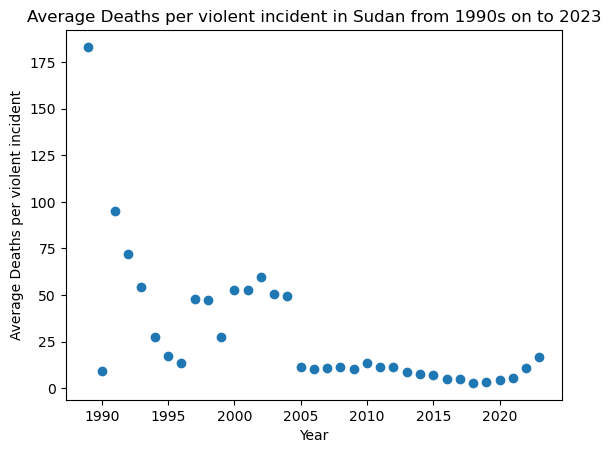

In [496]:
plt.scatter(x=year_averaged.index, y=year_averaged['total_deaths'])
plt.xlabel('Year')
plt.ylabel('Average Deaths per violent incident')
plt.title('Average Deaths per violent incident in Sudan from 1990s on to 2023')
plt.show()

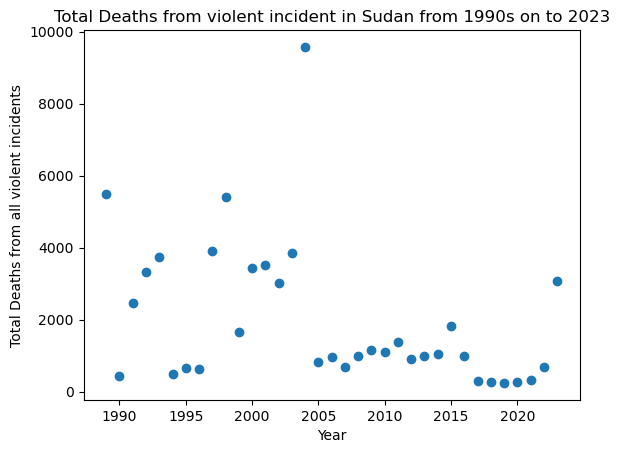

In [502]:
plt.scatter(x=year_summed.index, y=year_summed['total_deaths'])
plt.xlabel('Year')
plt.ylabel('Total Deaths from all violent incidents')
plt.title('Total Deaths from violent incident in Sudan from 1990s on to 2023')
plt.show()

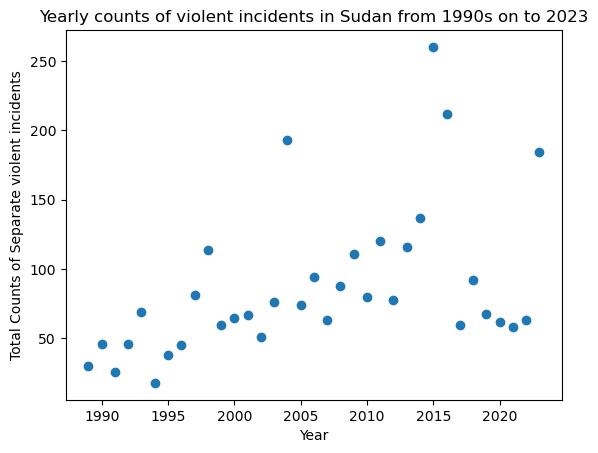

In [504]:
plt.scatter(x=year_counts.index, y=year_counts['total_deaths'])
plt.xlabel('Year')
plt.ylabel('Total Counts of Separate violent incidents')
plt.title('Yearly counts of violent incidents in Sudan from 1990s on to 2023')
plt.show()

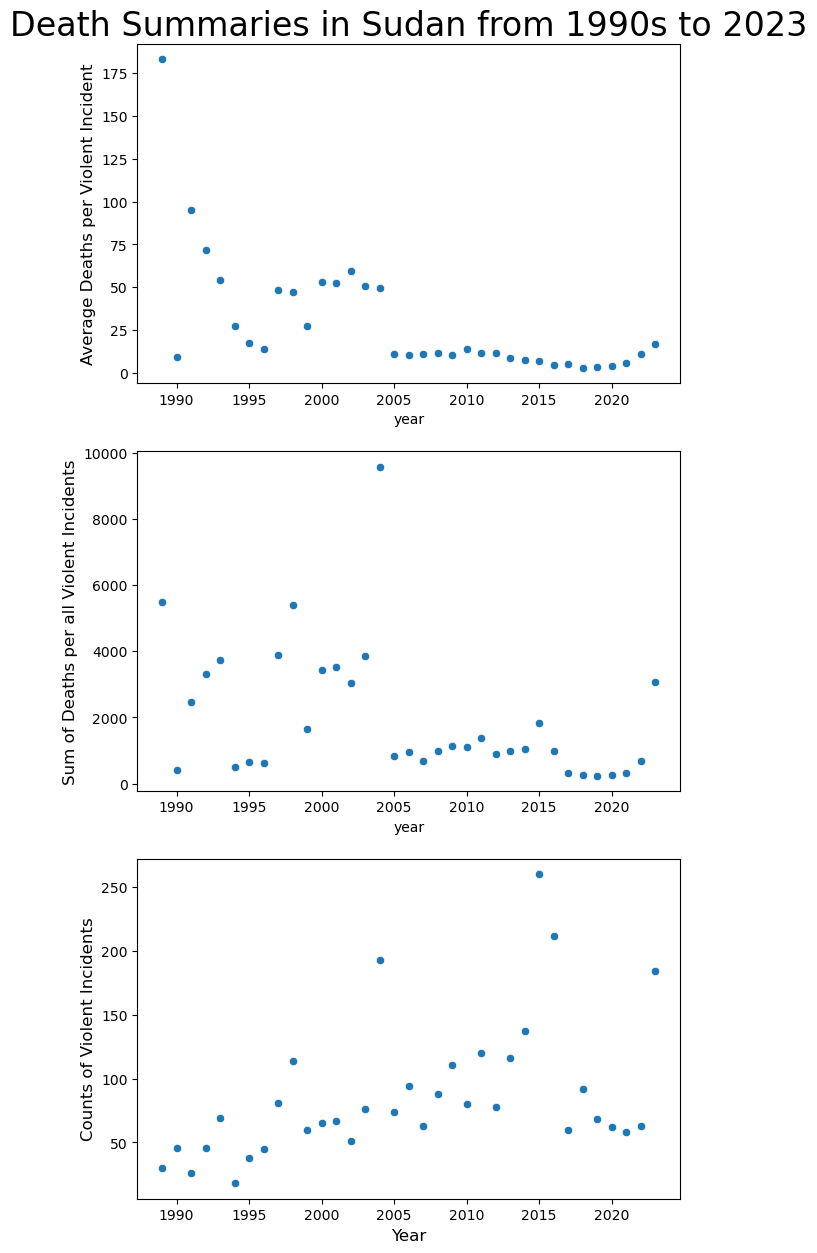

In [516]:
fig, ax = plt.subplots(3, 1, figsize=(7,15))

sns.scatterplot(x=year_averaged.index, y=year_averaged['total_deaths'], ax=ax[0])
sns.scatterplot(x=year_summed.index, y=year_summed['total_deaths'], ax=ax[1])
sns.scatterplot(x=year_counts.index, y=year_counts['total_deaths'], ax=ax[2])

 
ax[0].set_ylabel( "Average Deaths per Violent Incident" , size = 12 ) 
ax[0].set_title( "Death Summaries in Sudan from 1990s to 2023" , size = 24 ) 

ax[1].set_ylabel( "Sum of Deaths per all Violent Incidents" , size = 12 ) 

ax[2].set_xlabel( "Year" , size = 12 ) 
ax[2].set_ylabel( "Counts of Violent Incidents" , size = 12 ) 
ax[0].set_title( "Death Summaries in Sudan from 1990s to 2023" , size = 24 ) 

plt.show()

The general trends with violence over time in Sudan:

average death per violent incidence has gone down over the past three decades

the total deaths per year has gone down over the past three decades

the count of separate violent incidents has gone slightly up in the past three decades


b.) time series analysis of gdp deflator and year

In [519]:
year_averaged = df_w_o_loc.groupby(by='year').mean()

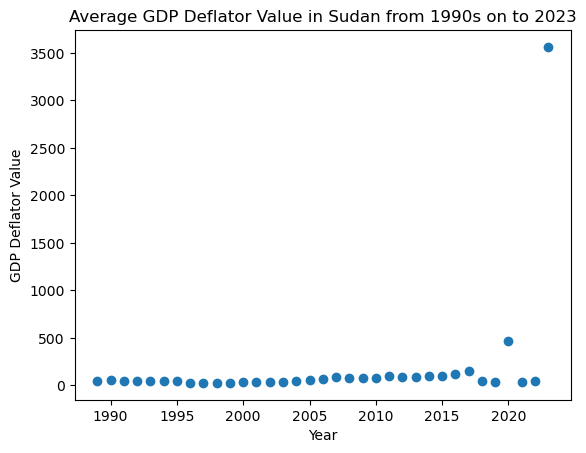

In [523]:
plt.scatter(x=year_averaged.index, y=year_averaged['GDP Deflator Value'])
plt.xlabel('Year')
plt.ylabel('GDP Deflator Value')
plt.title('Average GDP Deflator Value in Sudan from 1990s on to 2023')
plt.show()

What would it look like if it was just up to 2019 so no outliers

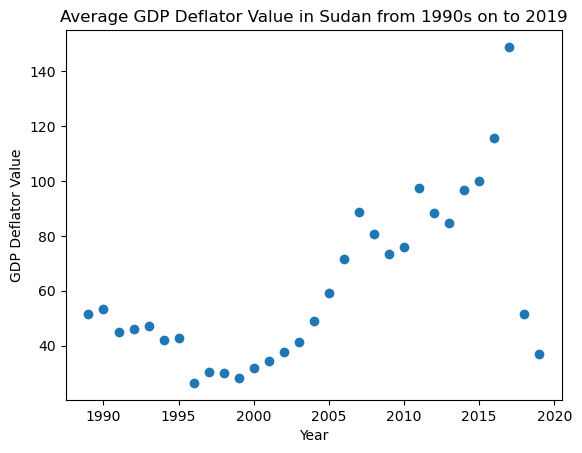

In [536]:
plt.scatter(x=year_averaged.index[:31], y=year_averaged['GDP Deflator Value'][:31])
plt.xlabel('Year')
plt.ylabel('GDP Deflator Value')
plt.title('Average GDP Deflator Value in Sudan from 1990s on to 2019')
plt.show()

5.) Correlation betwen GDP deflator values and violent incident analyses

a.) average deaths vs gdp deflator

In [541]:
avg_death = pd.concat([year_averaged['total_deaths'][:31], year_averaged['GDP Deflator Value']][:31], axis = 1)

In [543]:
avg_death_corr = avg_death.corr()

<Axes: >

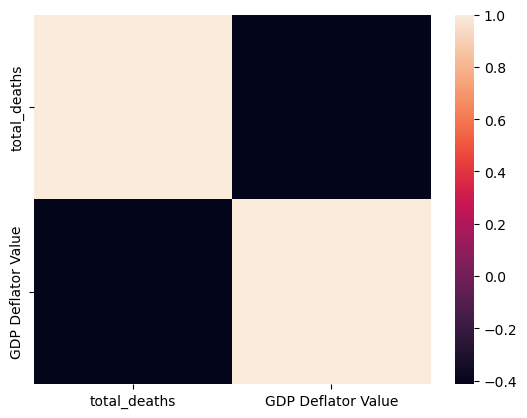

In [545]:
sns.heatmap(avg_death_corr)

The correlation seems to be weakley negative at -0.4

b.) sum of deaths per gdp deflator

In [550]:
sum_death = pd.concat([year_summed['total_deaths'][:31], year_averaged['GDP Deflator Value']][:31], axis = 1)

In [552]:
sum_death_corr = sum_death.corr()

<Axes: >

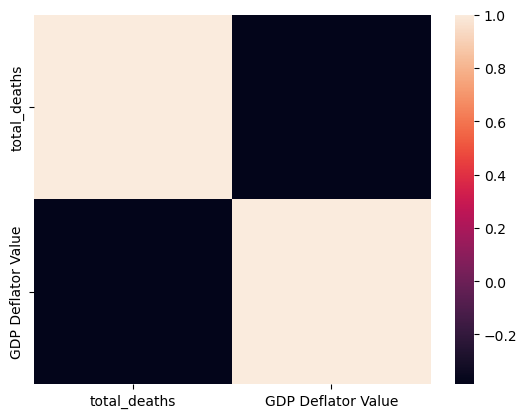

In [554]:
sns.heatmap(sum_death_corr)

weakly negatively correlated at -0.3

c.) counts of violent incidents

In [558]:
count_death = pd.concat([year_counts['total_deaths'], year_averaged['GDP Deflator Value']][:31], axis = 1)

In [560]:
count_death_corr = count_death.corr()

<Axes: >

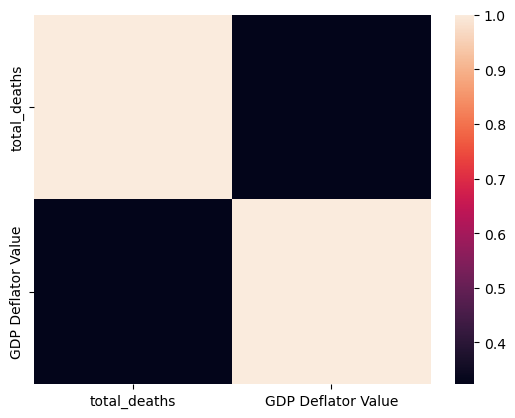

In [562]:
sns.heatmap(count_death_corr)

They are weakly positively correlated at 0.4

This will be the inferential statistics to see if there is significant fatalities differences based on group of location

In [679]:
def z_test(df, group_list):

    score_dict = {}

    seen = set()
    
    for x in range(len(group_list)):

        for y in range(len(group_list)):

            #seen.add((x,y))

            #if (x,y) in seen:
            #    continue

            if x == y:
                continue

            else:
                label = f'{group_list[x]} and {group_list[y]} score'

                x_len = len(df[df['general_location']==group_list[x]].total_deaths)
                y_len = len(df[df['general_location']==group_list[y]].total_deaths)
                
                x_mean = np.mean(df[df['general_location']==group_list[x]].total_deaths)
                y_mean = np.mean(df[df['general_location']==group_list[y]].total_deaths)

                x_std = np.std(df[df['general_location']==group_list[x]].total_deaths)
                y_std = np.std(df[df['general_location']==group_list[y]].total_deaths)

                num = x_mean - y_mean
                div = np.sqrt(x_std**2/x_len + y_std**2/y_len)

                
                z_score = num/div

                score_dict[label] = z_score


    return score_dict

            

        

In [681]:
z_test_locations = z_test(group_df, loc_descr)

In [683]:
print (z_test_locations)

{'village and town score': -1.9946321515342702, 'village and city score': 2.867007286652462, 'village and district score': 0.8429694981770327, 'village and state score': -1.3313558111454402, 'village and camp score': 2.788970825413992, 'village and locality score': -0.8536782270583626, 'village and area score': -1.0471178817607294, 'town and village score': 1.9946321515342702, 'town and city score': 6.373832632107404, 'town and district score': 3.0361496717519527, 'town and state score': 0.837740274869918, 'town and camp score': 5.646959036013841, 'town and locality score': -0.5222842053121327, 'town and area score': -0.6395978824746141, 'city and village score': -2.867007286652462, 'city and town score': -6.373832632107404, 'city and district score': -1.9259234860741736, 'city and state score': -5.730004224036264, 'city and camp score': 0.3920465717732383, 'city and locality score': -1.2672525453999788, 'city and area score': -1.5629878304822706, 'district and village score': -0.84296

use -1.96/1.96 (p = 0.05) for the significance threshold

In [685]:
print([k for k,v in z_test_locations.items() if v >= 1.96 or v <= -1.96])

['village and town score', 'village and city score', 'village and camp score', 'town and village score', 'town and city score', 'town and district score', 'town and camp score', 'city and village score', 'city and town score', 'city and state score', 'district and town score', 'district and state score', 'state and city score', 'state and district score', 'state and camp score', 'camp and village score', 'camp and town score', 'camp and state score']


There seems to be significant differences in violence information between the different geographical general labels

Notebook Summary:

1.) The dataset is clean minus several hundred duplicates; once removed the dataset was about 3000 observations

2.) Using cities and states in Sudan did not select for many observations in the dataset, instead the general location identifier in each 'where coordinates' like 'town', 'city', 'camp', etc. were used to group the different violent incidences

3.) An overwhelming amount of violent incidents in Sudan only lead to 0-50 deaths per each incidence.  It was extremely uncommon from 1990 to 2023 for any event to be higher than this range of deaths.

4.) 
a. average death per violent incidence has gone down over the past three decades

b. the total deaths per year has gone down over the past three decades

c. the count of separate violent incidents has gone slightly up in the past three decades


5.) GDP deflator is weakly correlated with average death per violent incidence and total death per year, but is weakly positively correlated with counts of violent incidence; potentially revealing that greater fluctuations in prices lead to more small, erratic violent scenarios rather than when the economy is more stable

6.) There were many significant distribution differences between the different groups made with the general location labeller, indicating that geographical information will be important in the model's understanding of the data

